This code takes the MOJAVE fluxdensity and creates the probability distribution used in the analysis from it. This is then folded into the analysis in MOJAVE02. 

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units
from astropy.time import Time as time
import pandas as pd
import scipy.interpolate
import scipy.integrate

In [144]:
mojave_data = np.load("./processed_data/mojave_likelihood.npz", allow_pickle = True)
cat_epoch = np.array(mojave_data["cat_epoch"])
flux_density = np.array(mojave_data["flux_density"])
cat_names = np.array(mojave_data["cat_names"])

average = np.nansum(flux_density)/len(flux_density)
difference = np.zeros(len(flux_density))
for i, adj_flux in enumerate(flux_density):
    difference[i] = (abs(adj_flux - average))**2
    
sigma = np.sqrt(np.nansum(difference)/len(difference))


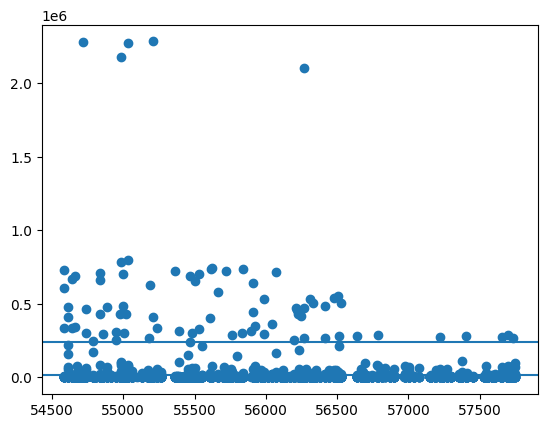

In [145]:
plt.scatter(cat_epoch, flux_density)
plt.axhline(y = average)
plt.axhline(y = average+2*sigma)

In [146]:
unique_epochs = np.unique(cat_epoch)
unique_fluxdensities = np.zeros(len(unique_epochs))

for i in range(len(unique_epochs)):
    unique_fluxdensities[i] = np.nansum(flux_density[cat_epoch == unique_epochs[i]])
    
    if unique_fluxdensities[i] < average + 2*sigma:
        unique_fluxdensities[i] = 0
    

In [147]:
sum_fluxdens = unique_fluxdensities[unique_fluxdensities != 0]
sum_epochs = unique_epochs[unique_fluxdensities != 0]


edges = np.arange(min(unique_epochs[unique_fluxdensities != 0]), max(unique_epochs[unique_fluxdensities != 0]), 36.5)
print(len(edges))
binned_fluxdensity = np.zeros(86)
for i in range(86):
    
    binned_fluxdensity[i] = np.sum(sum_fluxdens[np.logical_and(sum_epochs >= edges[i],sum_epochs<edges[i+1])])

87


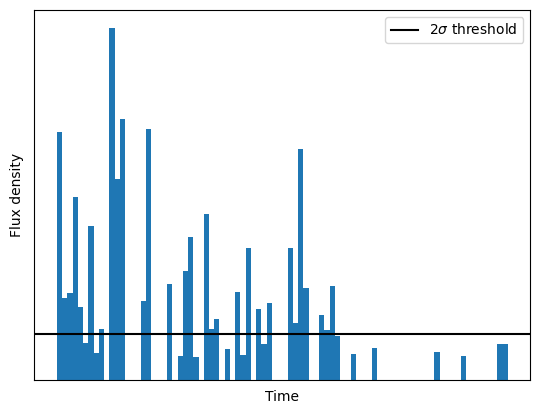

In [148]:
plt.figure(frameon = True)
plt.stairs(binned_fluxdensity,edges, fill = True)
plt.yticks(ticks = [], labels = None)
plt.xticks(ticks = [], labels = None)
plt.axhline(y = average + 5*sigma, color = "black", label = "2$\sigma$ threshold")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Flux density")
plt.savefig("probability_example_lightcurve.png", dpi = 300)
plt.show()

86
46


Text(0, 0.5, 'Probability')

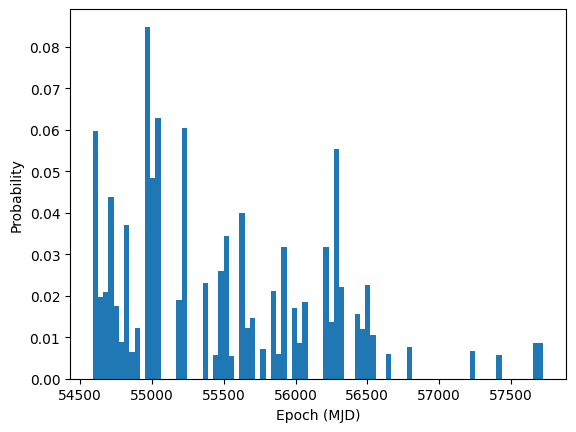

In [149]:
probability = np.zeros(86)
for i in range(len(binned_fluxdensity)):
    probability[i] = binned_fluxdensity[i] / np.sum(binned_fluxdensity)

prob_centers = (edges[:-1] + edges[1:]) / 2.0
print(len(prob_centers))
print(len(prob_centers[prob_centers>=56043]))

plt.stairs(probability, edges, fill = True)
plt.xlabel("Epoch (MJD)")
plt.ylabel("Probability")

In [150]:
icecube = np.load("./processed_data/output_icecube_data_time.npz", allow_pickle = True)
neutrino_time = np.array(icecube["data_day"])
data_dec = np.array(icecube["data_dec"])

overall_avg = len(neutrino_time)/(max(neutrino_time)-min(neutrino_time))
print(overall_avg)

294.57133579279247


In [151]:
neutrino_t_prob = np.zeros(len(neutrino_time))
for i in range(len(neutrino_time)):
    for k in range(len(probability)):
        if (np.logical_and(neutrino_time[i]>edges[k],neutrino_time[i]<=edges[k+1]) ==True):
            neutrino_t_prob[i]=probability[k]


In [152]:
np.savez("./processed_data/threshold_likelihood.npz",
         epoch = edges,
         probability = probability,
         T_S_i = neutrino_t_prob)